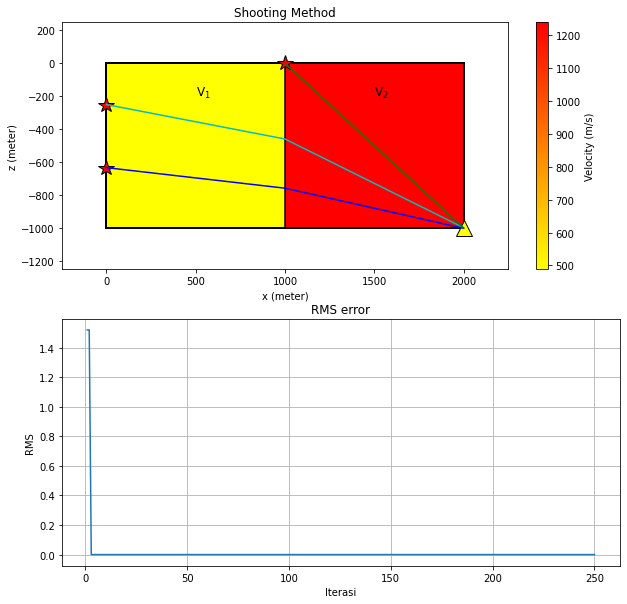

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Iqram Haris Fahromi / 12320021

# titik koordinat source dan receiver
s1 = np.array([0,-250]) # meter
s2 = np.array([0,-633]) # meter
s3 = np.array([1000, 0]) # meter
r1 = np.array([2000, -1000]) # meter
s_koor = np.array([s1, s2, s3]) 

# waktu tempuh observasi
t_obs11 = 3.020 # second
t_obs21 = 2.896 # second
t_obs31 = 1.139 # second
t_obs = np.array([t_obs11, t_obs21, t_obs31])

# variabel interpolasi mesh
xgrid = np.arange(0, 2001, 1000)
ygrid = np.arange(-1000, 1, 500)
mesh_x, mesh_y = np.meshgrid(xgrid, ygrid)

# fungsi menghitung panjang raypath
def panjang_raypath(s,r):
    l_sr = np.sqrt((r[0] - s[0])**2 + (r[1] - s[1])**2) # meter
    return l_sr

# menghitung panjang raypath
L = [] # meter
for i in range(len(s_koor)):
    z = panjang_raypath(s_koor[i],r1)
    L.append(z)
    
# menghitung model referensi (V0) 
v0 = np.sum((L/t_obs))/len(L) # m/s

# menghitung waktu tempuh kalkulasi (t_cal)
t_cal = np.array(L/v0) # s

# menghitung waktu tunda
dt = np.array(t_obs-t_cal)

# matriks kernel
G = np.zeros((len(L),2))
G[2,1] = L[-1]
for i in range(len(L)-1):
    for j in range(2):
        G[i,j] = L[i]/2
        
# solusi inversi
m_calc = np.linalg.inv((G.T).dot(G)).dot(G.T).dot(dt)

# menghitung dv asumsi >>>
dv = (-m_calc*(v0**2))/(1+(m_calc*v0))

# menghitung v
v = dv+v0

########## awal Ray tracing shooting
sudut_datang = np.arange(0, 25, 0.1)
bataslapisan_x = 1000

raypath_x = [np.zeros(3), np.zeros(3)]
raypath_y = [np.zeros(3),np.zeros(3)]

error_min = np.array([float('inf'), float('inf')])
error_dist = np.zeros(2)
titik_tengah = [np.zeros(2), np.zeros(2)]
dx=500

# variabel jumlah raypath yg ingin di-shooting
source = np.array([s1,s2]) 

# variabel menghitung eror
err = np.zeros(len(sudut_datang))

for j in range(len(sudut_datang)):
    for i in range(0,len(source)):
        
        dyy = np.tan(np.deg2rad(sudut_datang[j]))*dx

        if source[i][1] > r1[1]:
            bataslapisan_y = source[i][1] - dyy
        else:
            bataslapisan_x = source[i][1] + dyy
            
        sudut_transmisi = np.sin(np.deg2rad(sudut_datang[j])) * (v[1] / v[0])
        dyy = np.tan(sudut_transmisi)*dx

        if source[i][1] > r1[1]:
            receiver_temp_y = source[i][1] - dyy
        else:
            receiver_temp_y = source[i][1] + dyy
            
        error_dist[i] = np.sqrt((r1[0] - r1[0])**2 + (receiver_temp_y - r1[1])**2)
        
        
        # updating panjang raypath
        titik_tengah[i] = [bataslapisan_x, bataslapisan_y]
        L_baru = np.array([panjang_raypath(s1, titik_tengah[0])+panjang_raypath(titik_tengah[0], [2000,raypath_y[0][2]]),
                          panjang_raypath(s2, titik_tengah[1])+panjang_raypath(titik_tengah[1], [2000,raypath_y[1][2]]),
                          panjang_raypath(s3,r1)])
        
        err[i] = (raypath_y[1][2] - r1[1])**2
        
        # updating kernel baru
        G[0,0] = panjang_raypath(s1, titik_tengah[0])
        G[1,0] = panjang_raypath(s2, titik_tengah[1])
        G[0,1] = panjang_raypath(titik_tengah[0], [2000,raypath_y[0][2]])
        G[1,1] = panjang_raypath(titik_tengah[1], [2000,raypath_y[1][2]])
        G[2,0] = 0
        G[2,1] = panjang_raypath(s3,r1)
        
        
        # updating waktu tempuh kalkulasi (t_cal)
        t_cal = np.array(L_baru/v[i]) # s

        # updating waktu tunda
        dt = np.array(t_obs-t_cal)

        # updating inversi
        m_calc = np.linalg.inv((G.T).dot(G)).dot(G.T).dot(dt)

        # updating dv (asumsi >>>)
        dv = np.zeros(2)
        dv[i] = (-m_calc[i]*(v[i]**2))/(1+(m_calc[i]*v[i]))
        v = dv+v

        if error_dist[i] < error_min[i]:
            error_min[i] = error_dist[i]
            raypath_x[i] = [source[i][0], bataslapisan_x, r1[0]]
            raypath_y[i] = [source[i][1], bataslapisan_y, receiver_temp_y]
            
            # menyimpan v untuk interpolasi
            velocityplot = np.tile(v, (2, 1))
        

# plotting hasil
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

im = ax1.pcolor(mesh_x, mesh_y, velocityplot, cmap='autumn_r')
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Velocity (m/s)')
rectangle = patches.Rectangle((0, -1000), 2000, 1000, fc="none", edgecolor='black', linewidth=2)
ax1.add_patch(rectangle)

ax1.vlines(x=1000, ymin=-1000, ymax=0, color='black')
ax1.plot(s1[0], s1[1], marker="*", color="red", markersize=16, markeredgecolor='black')
ax1.plot(s2[0], s2[1], marker="*", color="red", markersize=16, markeredgecolor='black')
ax1.plot(s3[0], s3[1], marker="*", color="red", markersize=16, markeredgecolor='black')
ax1.plot(r1[0], r1[1], marker="^", color="yellow", markersize=16, markeredgecolor='black')
ax1.annotate("V$_1$", xy=[500, -200], size=12)
ax1.annotate("V$_2$", xy=[1500, -200], size=12)
ax1.plot(raypath_x[0], raypath_y[0], 'c')
ax1.plot(raypath_x[1], raypath_y[1], 'b')
ax1.plot([s3[0], r1[0]], [s3[1], r1[1]], 'g')
ax1.set_title("Shooting Method")
ax1.set_ylabel("z (meter)")
ax1.set_xlabel("x (meter)")
ax1.set_xlim(-250, 2250)
ax1.set_ylim(-1250, 250)

ax2.set_title("RMS error")
ax2.plot(np.arange(1,len(sudut_datang)+1), err)
ax2.set_ylabel("RMS")
ax2.set_xlabel("Iterasi")
ax2.grid()
plt.show()